# Stock Price Forcasting Using Tensorflow

In [194]:
import yfinance as yf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Miscellaneous Functions

In [195]:
def drop_columns(hist):
    return hist.drop(columns=['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])

def set_size(num, df):
    return df.shape[0]-num

In [196]:
## Collecting the data

In [197]:
data = yf.Ticker('MSFT')
df = drop_columns(data.history(start='2010-01-01'))
n = len(df)
df

,Close
Date,
2010-01-04,24.17
2010-01-05,24.18
2010-01-06,24.03
2010-01-07,23.78
2010-01-08,23.94
...,...
2020-09-21,202.54
2020-09-22,207.42
2020-09-23,200.59


In [198]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Close,2702.0,61.184985,47.88975,18.13,24.61,41.655,85.33,231.65


In [199]:
import datetime

date_time = pd.to_datetime(df.index, format='%d.%m.%Y')
timestamp_s = date_time.map(datetime.datetime.timestamp)
date_time

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2020-09-14', '2020-09-15', '2020-09-16', '2020-09-17',
               '2020-09-18', '2020-09-21', '2020-09-22', '2020-09-23',
               '2020-09-24', '2020-09-25'],
              dtype='datetime64[ns]', name='Date', length=2702, freq=None)

In [200]:
column_indices = {name: i for i, name in enumerate(df.columns)}
column_indices

{'Close': 0}

## Splitting the data

In [201]:
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

## Normalizing the data using regularization

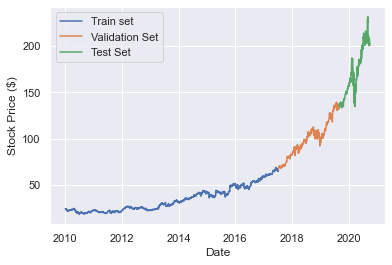

In [202]:
plt.plot(train_df['Close'])
plt.plot(val_df['Close'])
plt.plot(test_df['Close'])
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend(['Train set', 'Validation Set', 'Test Set'])
plt.show()

In [203]:
train_mean = train_df.mean()
train_std = train_df.std()

# train_df = (train_df - train_mean)/train_std
# val_df = (train_df - train_mean)/train_std
# test_df = (train_df - train_mean)/train_std

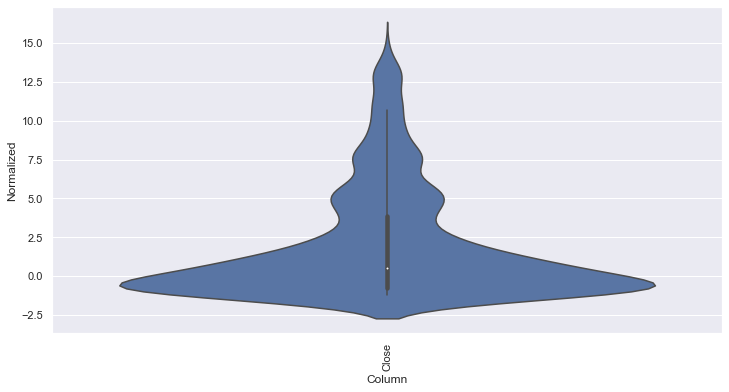

In [204]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Molding the Data

### This is only used to change the order of the columns and the type of the index. Mainly cos TensorFlow is a pile of ass and didn't like having a date in the index column

In [249]:
def change_index(df):
    df['Date'] = df.index
    df.index = range(1, len(df)+1)
    df.pop('Date')
    return df

train_df = change_index(train_df)
val_df = change_index(val_df)
val_df.index += 1891

dataset = tf.data.Dataset.from_tensor_slices(train_df)
dataset_val = tf.data.Dataset.from_tensor_slices(val_df)
for feat in dataset.take(10):
  print ('Features: {}'.format(feat))

Features: [24.17]
Features: [24.18]
Features: [24.03]
Features: [23.78]
Features: [23.94]
Features: [23.64]
Features: [23.48]
Features: [23.7]
Features: [24.18]
Features: [24.1]


In [261]:
train_input = train_df.to_numpy()
train_input.shape

(1891, 1)

## Getting some baseline readings

In [263]:
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

# model = tf.keras.models.Sequential([
#     tf.keras.layers.Flatten(input_shape=(1891, 1)),
#     tf.keras.layers.Dense(1)
# ])

model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[1891,1])
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(train_input, epochs=20)
history

Epoch 1/20


ValueError: in user code:

    d:\Coding\ml_forecasting\forecast\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    d:\Coding\ml_forecasting\forecast\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    d:\Coding\ml_forecasting\forecast\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    d:\Coding\ml_forecasting\forecast\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    d:\Coding\ml_forecasting\forecast\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    d:\Coding\ml_forecasting\forecast\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    d:\Coding\ml_forecasting\forecast\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    d:\Coding\ml_forecasting\forecast\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    d:\Coding\ml_forecasting\forecast\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:176 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_48 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 1]


## Implementing Simple RNN

In [ ]:
plt.plot(train_df['Close'])
plt.plot(val_df['Close'])
plt.plot(test_df['Close'])
plt.legend(['Train', 'Validate', 'Test'])
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.show()

In [ ]:
## Simple one neuron RNN. Just to test the code
MAX_EPOCHS = 20

def compile_and_fit(model, df_train, df_val, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    model.compile(loss=tf.losses.MeanSquaredError(), 
                    optimizer=tf.optimizers.Adam(),
                    metrics=[tf.metrics.MeanAbsoluteError()])
    history = model.fit(df.index, df['Close'], epochs=MAX_EPOCHS, validation_data=df_val['Close'], callbacks=                                          [early_stopping])
    return history

model_simpleRNN = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

# history = compile_and_fit(model_simpleRNN, train_df, val_df)